In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path

import pickle
import networkx as nx
from pyvis import network as net
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline

C:\Users\jesse\miniconda3\envs\imibigdata\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Task One

In [9]:
KYCPATH = Path('./data/raw/kyc.csv')
kyc = pd.read_csv(KYCPATH)

First, we can see that the data is heavily imbalanced, with only ~2% positive labels

In [10]:
kyc.groupby('label')['cust_id'].count()

label
0    190275
1      5514
Name: cust_id, dtype: int64

Breaking down the labels, we can see that age and tenure can discriminate between labels

label
0    35.670687
1    41.428908
Name: age, dtype: float64

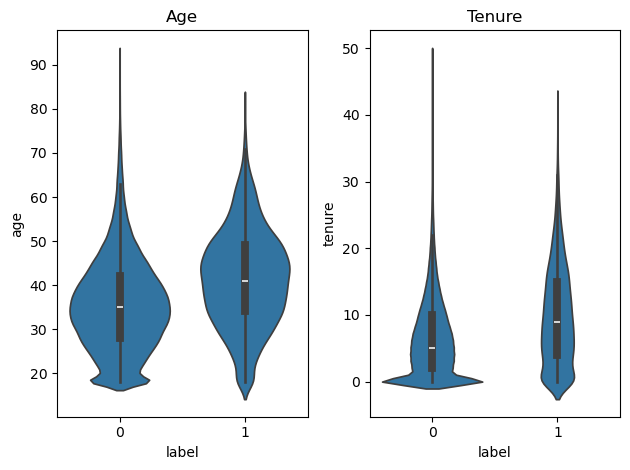

In [26]:
display(kyc.groupby('label')['age'].mean())

f,axs=plt.subplots(1,2)
sns.violinplot(x=kyc['label'], y=kyc['age'], ax=axs[0])
sns.violinplot(x=kyc['label'], y=kyc['tenure'], ax=axs[1])

axs[0].set_title('Age')
axs[1].set_title('Tenure')

plt.tight_layout()
plt.show()

Gender is less discriminating - there are no differences in male/female/other in positive vs negative labels.

In [26]:
pd.crosstab(kyc['label'], kyc['gender'], normalize='index')

gender,female,male,other
label,,,
0,0.450679,0.449718,0.099603
1,0.455205,0.446863,0.097933


There are 250 unique occupations in the KYC dataset. Of these, 22 of these have no positive labels

In [37]:
len(kyc.occupation.unique())

250

In [38]:
df = kyc.groupby('occupation', as_index=False)['label'].sum()
len(df[df.label==0])

22

The occupations with the most positive labels are `Other`, `Real Estate Broker`, and `Unemployed`. However, looking at the *frequency* of positive labels, the top occupations are `Import/Export Business Owner`, `Online Gambling Site Operator` and `Free Trade Zone Operator`. Clearly, occupation will have a significant impact on money laundering likelihood.

In [49]:
df = kyc.groupby('occupation', as_index=False)['label'].sum()
df.sort_values(by='label', ascending=False)

,occupation,label
164,Other,180
195,Real Estate Broker,178
233,Unemployed,167
32,Car Dealership Owner,161
91,"Freelancer (e.g., Graphic Designer, Writer)",149
...,...,...
69,Entomologist,0
107,Hydrologist,0
102,Herpetologist,0
147,Mycologist,0


In [50]:
df = kyc.groupby('occupation', as_index=False)['label'].mean()
df.sort_values(by='label', ascending=False)

,occupation,label
110,Import/Export Business Owner,0.423387
160,Online Gambling Site Operator,0.404762
90,Free Trade Zone Operator,0.401163
153,Notary Public,0.400000
55,Cryptocurrency Trader,0.398104
...,...,...
165,Paleontologist,0.000000
107,Hydrologist,0.000000
162,Ornithologist,0.000000
109,Illustrator,0.000000


In [48]:
df[df.occupation=='Real Estate Agent']

,occupation,label
194,Real Estate Agent,0.031877


# Task Two

In [2]:
KYCPATH = Path('./data/raw/kyc.csv')
WPATH = Path('./data/raw/wire.csv')
EPATH = Path('./data/raw/emt.csv')
CPATH = Path('./data/raw/cash.csv')

kyc = pd.read_csv(KYCPATH)
wt = pd.read_csv(WPATH)
emt = pd.read_csv(EPATH)
cash = pd.read_csv(CPATH)

In [3]:
print(len(kyc))
print(len(wt))
print(len(emt))
print(len(cash))

195789
67872
506451
212532


In [4]:
external = []
external.extend(emt[emt.cust_id_sender.str.contains('EXT')]['cust_id_sender'].values.tolist())
external.extend(emt[emt.cust_id_receiver.str.contains('EXT')]['cust_id_receiver'].values.tolist())
external.extend(wt[wt.cust_id_sender.str.contains('EXT')]['cust_id_sender'].values.tolist())
external.extend(wt[wt.cust_id_receiver.str.contains('EXT')]['cust_id_receiver'].values.tolist())

print(f'There are {len(set(external))} unique external customers')

There are 104219 unique external customers


## EMT Message Parsing
First, some pre-processing

In [5]:
emt.trxn_message = emt.trxn_message.str.lower()
emt.trxn_message = emt.trxn_message.str.replace(r'[^\w\s]', '')
emt.to_csv(EPATH, index=False)

In [6]:
print(f'There are {len(emt[pd.notna(emt.trxn_message)])} e-transfer messages')

There are 41225 e-transfer messages


### Using Zero Shot Classification
One idea for detecting wildlife trafficking related messages was to use zero-shot classification techniques.

Using a zero-shot classification technique with BART from facebook/huggingface with the labels `illegal wildlife trafficking` and `not illegal wildlife trafficking` we can see that there are a lot of confounding examples: messages like "leopard print leggings" and "shark skin phone case" are misclassified by the LLM.

In [7]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

In [116]:
def classify_msg(classifier, msg, labels, q=None):
    output = classifier(msg, labels)
    output = dict(zip(output['labels'], output['scores']))
    
    if q:
        return output[q] 
    else:
        return output[labels[0]]

    
msgs = emt[pd.notna(emt.trxn_message)][['trxn_id', 'trxn_message']]
labels = ['illegal wildlife trafficking', 'not illegal wildlife trafficking']
test = msgs.sample(1000).copy()

test['score'] = test.apply(lambda r: classify_msg(classifier, r.trxn_message, labels), axis=1)

338.2621500492096


,trxn_id,trxn_message,score
332003,QZAC95899094,Coffee shop,0.057526
197197,PXKK21485426,Nails did,0.250371
389241,ZGJP70253997,Pizza night,0.097863
309074,ZPYR36350848,old debt,0.330101
367230,HSMU31442405,Trivia prize,0.254460
...,...,...,...
240774,SFLI26808372,Covering my half of the dinner,0.243961
61147,XSXW22940924,Paying back borrowed money,0.258323
308848,DSRE26491315,Pitched in for your birthday gift,0.091306
218233,BHEP71588735,Coffee run,0.085343


In [117]:
test.sort_values('score')

,trxn_id,trxn_message,score
4155,MHOE70796434,Charity donation,0.013745
309545,QPHS11640556,Charity donation,0.013745
249202,KJXO99518509,Flea market,0.016959
484088,XJJU77211973,Grocery run,0.019447
272700,WQKA11762800,Grocery run,0.019447
...,...,...,...
201126,WYOV78305919,Movers charge,0.574710
310778,EYPL29649215,Leopard print leggings,0.600782
405966,PAIL92355460,Leopard spot dress refund,0.629985
218103,CKUM58467575,Shark skin laptop sleeve,0.709061


In [169]:
test[test.score >= 0.5].sample(10)

,trxn_id,trxn_message,score
491876,DFVV77634234,Rush shipping,0.509673
123629,TDEG22768596,new book,0.506197
405966,PAIL92355460,Leopard spot dress refund,0.629985
191167,SYYC38765093,"fined, sorry",0.516148
499692,SVVZ91014315,Elephant print leggings,0.903360
155330,QZVZ40760415,"Rent due, hurry",0.537019
382609,LOWQ16167088,Elec. bill,0.526559
310778,EYPL29649215,Leopard print leggings,0.600782
218103,CKUM58467575,Shark skin laptop sleeve,0.709061
374327,XSLN85900117,Elephant print throw blanket,0.560219


### Embedding Analysis
Another option is to use LLMs to encode emt messages and a query: 
1. Encode all emt messages
2. Encode query (e.g. "wildlife trafficking")
3. Calculate similarity of embeddings to query

However, as shown below this overwhelmingly flags messages containing pet or zoo-related information.

In [120]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

''' Don't run this - takes a while. Just load the pickle already generated
embeddings = model.encode(emt[~(emt['emt message'].isna())]['emt message'].tolist())
embeddings_dct = {row['trxn_id'] : embeddings[index] for index, row in emt[~(emt['emt message'].isna())].reset_index().iterrows()}
with open('emt_msg_embds.pkl', 'wb') as f:
    pickle.dump(embeddings_dct, f)
'''

with open('./data/processed/emt_msg_embds.pkl', 'rb') as f:
    emt_msg_embds = pickle.load(f)

modules.json: 100%|███████████████████████████████████| 349/349 [00:00<?, ?B/s]
C:\Users\jesse\miniconda3\envs\imibigdata\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning:

`huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jesse\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development

config_sentence_transformer

In [ ]:
search = model.encode('wildlife') + model.encode('animal') - model.encode('pets') - model.encode('backpacking')
sims = {i : util.cos_sim(search, emt_msg_embds[i]).item() for i in emt_msg_embds.keys()}

emt['sim'] = emt['trxn_id'].map(sims)
emt[(~emt.sim.isnull()) & (emt.sim>0.1)].sort_values('sim')

In [264]:
search = model.encode('traditional medicine') + model.encode('wildlife')
sims = {i : util.cos_sim(search, emt_msg_embds[i]).item() for i in emt_msg_embds.keys()}

emt['sim'] = emt['trxn_id'].map(sims)
emt[(~emt.sim.isnull()) & (emt.sim>0.1)].sort_values('sim')

,cust_id_sender,cust_id_receiver,name_sender,name_receiver,trxn_message,emt_value,trxn_id,sim,regex_flag
437771,EXTERNAL138570,CUST48759333,RANDALL HODGE,MARK BROWN,Pet care,42.0,QNKC72198725,0.435839,0
405713,CUST11254614,EXTERNAL538749,KOTOV ANATOLIJ ANTONOVICH,JULES BISSON,Pet care,20.0,LHIY40134635,0.435839,0
246396,EXTERNAL320612,CUST77664444,BRENDA ROSS,STEVEN WOODWARD,Pet care,39.0,HGOP23908600,0.435839,0
22521,EXTERNAL639553,CUST12560490,MICHEAL MOORE,CHERYL WHITNEY,Pet care,64.0,UXNO69794713,0.435839,0
324550,CUST54867692,EXTERNAL212275,VIDUR SEKHON,ANTHONY LARSON,Weed,51.0,CBYH45426265,0.437376,0
447077,CUST83857868,CUST23317536,EMMANUELLE VAILLANCOURT,MARIA VAZQUEZ,Weed,33.5,VMMI28063723,0.437376,0
502234,CUST48660377,CUST17141355,ZHANG NA,MATTHEW MCGEE,pet stuff,59.5,KJQV40332026,0.439850,0
235183,CUST22386590,CUST45211744,SARAH MCCARTY,ALLEN GRAHAM,Pet stuff,32.0,YREV75050746,0.439850,0
237574,CUST12711395,EXTERNAL500565,MRS. CRYSTAL STEWART MD,STEVE ARCHER,Pet food;,34.5,AOMM49757198,0.442415,0
385449,EXTERNAL584607,CUST78034481,GRÉGOIRE TARDIF-ROY,MRS. AMY WOOD,herb plants,24.5,FMHQ38538134,0.463167,0


Even using common tricks to combine/subtract encodings (e.g. `enc('animal') - enc('pets') - enc('car parts')`) only results in one suspicious e-transfer message: David wilkerson sending money for "moose meat" to Steven Cruz.

In [8]:
search = model.encode('wildlife') + model.encode('animal') - model.encode('pets') - model.encode('backpacking')
sims = {i : util.cos_sim(search, emt_msg_embds[i]).item() for i in emt_msg_embds.keys()}

emt['sim'] = emt['trxn_id'].map(sims)
emt[(~emt.sim.isnull()) & (emt.sim>0.1)].sort_values('sim')

NameError: name 'model' is not defined

### Hardcoding
Are there even animal-trafficking related messages, or all they all just for pet-related stuff? Let's look at `bears` - an animal commonly trafficked in Canada for its parts, according to Fintrac - and see what we find.

In [308]:
# function takes iterable of messages and returns list of if its about animal trafficking or no
def classify_message_animal_trafficking(messages: pd.Series, positives, negatives):
#     messages = pd.Series(messages) # to use str contains

    pattern = '|'.join([f'\\b{k}\\b' for k in keywords])

    classification = (messages.str.contains(pattern, case=False, na=False))
    return classification.astype(int)

In [310]:
def classify_message_animal_trafficking(messages: pd.Series, positives: list, negatives=None):
    """Creates a boolean list based on the contents of a keywords in a list
    
    Flags the contents of a message based on a list of search terms (positive), provided that message doesn't match 
    a whitelisted term (negative).
    
    Args: 
        messages: a pandas series containing e-transfer messages
        positives: a list of strings containing regex flags which indicate animal trafficking
        negatives: (optional) a list of strings containing regex flax which DONT indicate animal trafficking
    """
    positive_pattern = '|'.join([f'\\b{p}\\b' for p in positives])
    classification = (messages.str.contains(positive_pattern, case=False, na=False))
    
    if negatives is not None:
        negative_pattern = '|'.join([f'{n}' for n in negatives])
        classification = classification & (~messages.str.contains(negative_pattern, case=False, na=False))
    
    return classification.astype(int)

In [328]:
emt['regex_flag'] = classify_message_animal_trafficking(emt['trxn_message'], ['bears?', 'grizzly', 'polar', 'gall', 'fangs?', 'penis'])
emt[emt['regex_flag']==1]

,cust_id_sender,cust_id_receiver,name_sender,name_receiver,trxn_message,emt_value,trxn_id,regex_flag
47732,CUST71464959,CUST26353050,OLIVIER CLOUTIER,MARY BELL,drank ur bear,5.0,JKWK69777313,1
51050,CUST89147857,CUST55120106,RANBIR BAHRI,PATRICK MULLEN,Bear market investing book,20.0,DLJW10419221,1
51278,CUST18895794,CUST56618289,JASMINE PETERSON,THEODORE WATSON,Bear market investment book,30.0,ZDKG78259225,1
134658,CUST85769551,CUST33059790,DAVID WILKERSON,DR.JOHN WADE,"For bear skin, as dicussed",4260.0,ZGAN21196261,1
293024,EXTERNAL808245,CUST19857312,WILLIE RAMIREZ,CATHERINE MCDANIEL,Bull and Bear steakhouse dinner,80.0,TSNO31371613,1
402320,CUST72019575,EXTERNAL307313,TARA CARTER,BRANDON WILCOX,Bear market investment book,26.5,APOR13055009,1
421678,CUST90429433,EXTERNAL549406,DENNIS COLLINS,DEANNA THOMPSON,Bear Grylls survival guide,10.0,HRVV43041443,1
427195,EXTERNAL492318,CUST86668621,SÉBASTIEN SOUCY,ASHLEY ALLEN,Bear market investment book,29.5,YWTJ97043059,1
446082,CUST85769551,CUST33059790,DAVID WILKERSON,DR.JOHN WADE,bear fangs,2200.0,XGAL12621643,1
466392,CUST40204831,CUST38099582,WENDY HALL,CHRISTOPHER NASH,Bear Grylls survival book,17.0,XOMJ11964544,1


There are a couple suspicious transactions, between Dr. John Wade and David Wilkerson, and a couple common terms which we can add to a "negatives" list. Although this method is much more manual, it leverages expert knowledge and results in much more precise flagging.

In [330]:
positives = ['bears?', 'grizzly', 'polar', 'gall', 'fangs?', 'penis']
negatives = ['bear market', 'bear grylls']

emt['regex_flag'] = classify_message_animal_trafficking(emt['trxn_message'], positives, negatives)
emt[emt['regex_flag']==1]

,cust_id_sender,cust_id_receiver,name_sender,name_receiver,trxn_message,emt_value,trxn_id,regex_flag
47732,CUST71464959,CUST26353050,OLIVIER CLOUTIER,MARY BELL,drank ur bear,5.0,JKWK69777313,1
134658,CUST85769551,CUST33059790,DAVID WILKERSON,DR.JOHN WADE,"For bear skin, as dicussed",4260.0,ZGAN21196261,1
293024,EXTERNAL808245,CUST19857312,WILLIE RAMIREZ,CATHERINE MCDANIEL,Bull and Bear steakhouse dinner,80.0,TSNO31371613,1
446082,CUST85769551,CUST33059790,DAVID WILKERSON,DR.JOHN WADE,bear fangs,2200.0,XGAL12621643,1
490240,CUST59323850,EXTERNAL985369,CHARLES MARCOTTE,LAURENCE BERNIER,Grizzly grip tape for skateboard,13.0,FIJX81285524,1


# Network exploration

# Task Three